In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pydicom
import tensorflow as tf
import skimage

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import CSVLogger

Using TensorFlow backend.


In [3]:
def load_images_from_folder(folder):
    images = []
    for i in range(1,601):
        filename = "Mask ("+str(i)+").tif"
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [4]:
masks = load_images_from_folder("mask")

In [5]:
def load_dicom_images_from_folder(folder):
    images = []
    for i in range(1,601):
        filename = "Image ("+str(i)+").dcm"
        data = pydicom.dcmread(os.path.join(folder,filename))
        img = data.pixel_array
        if img is not None:
            images.append(img)
    return images

In [6]:
images = load_dicom_images_from_folder("images")

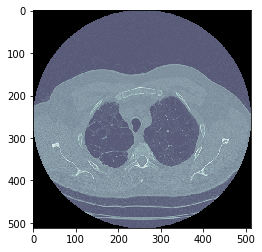

In [7]:
plt.imshow(images[179], cmap=plt.cm.bone)
plt.show()

In [8]:
maskg = []
for i in range(600):    
    maskg.append(cv2.cvtColor(masks[i], cv2.COLOR_BGR2GRAY))

In [9]:
idx = []
count = 0
for i in range(600):
    if(images[i].shape != maskg[i].shape):
        idx.append(i)
        count+=1
print(idx,count)

[] 0


In [10]:
ildimg = []
for i in range(600): 
    if i not in idx:
        ildimg.append(np.multiply(images[i],maskg[i]))

In [11]:
def crop(img, tol=0):
    mask = img>tol
    m,n = img.shape
    mask0,mask1 = mask.any(0),mask.any(1)
    col_start,col_end = mask0.argmax(), n-mask0[::-1].argmax()
    row_start,row_end = mask1.argmax(),m-mask1[::-1].argmax()
    cropped = img[row_start:row_end,col_start:col_end]
    #final = img.reshape(cropped,(512,512))
    return cropped

In [12]:
croppi = []
for i in range (600):
    #print(i)
    a = crop(ildimg[i])
    croppi.append(a)
    
croppi = np.asarray(croppi)

In [13]:
final = []
for i in range(600):
    croppi[i] = np.asarray(croppi[i])
    final.append(cv2.resize(croppi[i],(32,32),interpolation=cv2.INTER_AREA))

In [14]:
final = np.asarray(final)
final.shape

(600, 32, 32)

In [15]:
target = []
for i in range(6):
    for j in range(i*100,(i+1)*100):
        target.append(i)
target = np.asarray(target)

In [ ]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(final, target, test_size=0.1, random_state=10)
xtrain = np.asarray(xtrain)
ytrain = np.asarray(ytrain)
xtest = np.asarray(xtest)
ytest = np.asarray(ytest)

xtrain = xtrain.reshape(xtrain.shape[0], 256, 256,1)
xtest = xtest.reshape(xtest.shape[0], 256, 256,1)

xtrain = xtrain.astype('float32')
xtest = xtest.astype('float32')
xtrain /= 255
xtest /= 255

from keras.utils import np_utils
ytrain = np_utils.to_categorical(ytrain, 6)
ytest = np_utils.to_categorical(ytest, 6)
ytrain.shape

classifier = Sequential()

classifier.add(Conv2D(filters = 56,kernel_size = (3,3), activation = 'relu', input_shape = (256,256,1)))
classifier.add(MaxPooling2D(pool_size = (2,2)))

classifier.add(Conv2D(32,(3,3),activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))

classifier.add(Flatten())

classifier.add(Dense(units = 64, activation = 'relu'))

classifier.add(Dense(units = 6 , activation = 'softmax'))

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy','accuracy'])

classifier.summary()

classifier.fit(xtrain,ytrain, epochs = 1, steps_per_epoch = 3)

In [ ]:
from keras.utils import to_categorical

img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 1)

# Prepare the training images
xtrain = xtrain.reshape(xtrain.shape[0], img_rows, img_cols, 1)
xtrain = xtrain.astype('float32')
xtrain /= 255

# Prepare the test images
xtest = xtest.reshape(xtest.shape[0], img_rows, img_cols, 1)
xtest = xtest.astype('float32')
xtest /= 255


In [ ]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

cnn1 = Sequential()
cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Dropout(0.2))

cnn1.add(Flatten())

cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(6, activation='softmax'))

cnn1.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
cnn1.summary()

In [ ]:
cnn1.fit(xtrain,ytrain, epochs = 100, steps_per_epoch = 25)

In [ ]:
xtrain.shape

In [ ]:
score1 = cnn1.evaluate(xtest, ytest, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

In [ ]:
cnn3 = Sequential()
cnn3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
cnn3.add(MaxPooling2D((2, 2)))
cnn3.add(Dropout(0.25))

cnn3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2)))
cnn3.add(Dropout(0.25))

cnn3.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn3.add(Dropout(0.4))

cnn3.add(Flatten())

cnn3.add(Dense(128, activation='relu'))
cnn3.add(Dropout(0.3))
cnn3.add(Dense(6, activation='softmax'))

cnn3.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
cnn3.summary()

In [ ]:
cnn3.fit(xtrain,ytrain, epochs = 50, steps_per_epoch = 50)

In [ ]:
score3 = cnn3.evaluate(xtest, ytest, verbose=0)
print('Test loss:', score3[0])
print('Test accuracy:', score3[1])

In [ ]:
from keras.layers import BatchNormalization

cnn4 = Sequential()
cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
cnn4.add(BatchNormalization())

cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.7))

cnn4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.7))

cnn4.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.7))

cnn4.add(Flatten())

cnn4.add(Dense(512, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.7))

cnn4.add(Dense(128, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.7))

cnn4.add(Dense(6, activation='softmax'))

cnn4.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
cnn4.summary()

In [ ]:
cnn4.fit(xtrain,ytrain, epochs = 50, steps_per_epoch = 50)

In [ ]:
score4 = cnn4.evaluate(xtest, ytest, verbose=0)
print('Test loss:', score4[0])
print('Test accuracy:', score4[1])

In [ ]:
xtrain2 = []
xtest2 = []
for i in range(540):
    xtrain2.append(cv2.cvtColor(xtrain[i],cv2.COLOR_GRAY2RGB))
    
for i in range(60):
    xtest2.append(cv2.cvtColor(xtest[i],cv2.COLOR_GRAY2RGB))


In [ ]:

import keras
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.layers import Dense, Dropout
from keras.models import Model
from keras import models
from keras import layers
from keras import optimizers

# Create the base model of VGG19
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape = (32, 32, 3), classes = 6)

# Preprocessing the input 
xtrain2 = np.array(xtrain2)
xtrain2 = preprocess_input(xtrain2.astype(int))
xtest2 = np.array(xtest2)
xtest2 = preprocess_input(xtest2.astype(int))

# Extracting features
train_features = vgg19.predict(np.array(xtrain2))
test_features = vgg19.predict(np.array(xtest2))



In [ ]:
train_features.shape

In [ ]:
# Flatten extracted features
train_features = np.reshape(train_features, (540, 1*1*512))
test_features = np.reshape(test_features, (60, 1*1*512))

# Add Dense and Dropout layers on top of VGG19 pre-trained
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=1 * 1 * 512))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1025, activation='relu'))
model.add(layers.Dropout(0.7))

model.add(layers.Dense(6, activation="softmax"))

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
model.fit(train_features,ytrain, epochs = 22, steps_per_epoch = 25,validation_data=(test_features, ytest),validation_steps = 10)

In [ ]:
scorevgg = model.evaluate(test_features, ytest, verbose=0)
print('Test loss:', scorevgg[0])
print('Test accuracy:', scorevgg[1])

In [ ]:
#final is the image dataset and target is the y 

In [16]:
flip = []
for i in range(len(final)):
    flip.append(np.fliplr(final[i]))

In [17]:
plus90 = []
for i in range(len(final)):
    plus90.append(cv2.rotate(final[i], cv2.ROTATE_90_CLOCKWISE))

In [18]:
minus90 = []
for i in range(len(final)):
    minus90.append(cv2.rotate(final[i], cv2.ROTATE_90_COUNTERCLOCKWISE))

In [19]:
plus180 = []
for i in range(len(final)):
    plus180.append(cv2.rotate(final[i], cv2.ROTATE_180))

In [20]:
from skimage.transform import rescale
scaled2 = []
for i in range(len(final)):
    scaled2.append(skimage.transform.rescale(final[i], scale=2.0, mode='constant')[16:48,16:48])

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [21]:
np.amax(final[0])

61290

In [22]:
aug = []
aug = np.concatenate((final,flip,plus90,minus90,plus180,scaled2))

In [23]:
for i in range(len(aug)):
    aug[i] = ((aug[i]/np.amax(aug[i]))*255).astype('uint8')

In [24]:
ntarget = []
ntarget = np.concatenate((target,target,target,target,target,target))

In [25]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(aug, ntarget, test_size=0.1, random_state=10)
xtrain = np.asarray(xtrain)
ytrain = np.asarray(ytrain)
xtest = np.asarray(xtest)
ytest = np.asarray(ytest)

In [26]:
from keras.utils import to_categorical

img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 1)

# Prepare the training images
xtrain = xtrain.reshape(xtrain.shape[0], img_rows, img_cols, 1)
xtrain = xtrain.astype('float32')
xtrain /= 255

# Prepare the test images
xtest = xtest.reshape(xtest.shape[0], img_rows, img_cols, 1)
xtest = xtest.astype('float32')
xtest /= 255

In [27]:
xtrain[0].shape

(32, 32, 1)

In [28]:
xtrain2 = []
xtest2 = []
for i in range(3240):
    print(i)
    xtrain2.append(cv2.cvtColor(xtrain[i],cv2.COLOR_GRAY2RGB))
    
for i in range(360):
    xtest2.append(cv2.cvtColor(xtest[i],cv2.COLOR_GRAY2RGB))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777


In [29]:

import keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

# Create the base model of VGG19
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape = (32, 32, 3), classes = 6)

# Preprocessing the input 
xtrain2 = np.array(xtrain2)
xtrain2 = preprocess_input(xtrain2.astype(int))
xtest2 = np.array(xtest2)
xtest2 = preprocess_input(xtest2.astype(int))

# Extracting features
train_features = vgg19.predict(np.array(xtrain2))
test_features = vgg19.predict(np.array(xtest2))

In [34]:
# Flatten extracted features
train_features = np.reshape(train_features, (3240, 1*1*512))
test_features = np.reshape(test_features, (360, 1*1*512))

# Add Dense and Dropout layers on top of VGG19 pre-trained
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=1 * 1 * 512))

model.add(layers.Dense(1025, activation='relu'))

model.add(layers.Dense(2051, activation='relu'))

model.add(layers.Dense(1025, activation='relu'))

model.add(layers.Dense(512, activation='relu'))

model.add(layers.Dense(6, activation="softmax"))

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_7 (Dense)              (None, 1025)              525825    
_________________________________________________________________
dense_8 (Dense)              (None, 2051)              2104326   
_________________________________________________________________
dense_9 (Dense)              (None, 1025)              2103300   
_________________________________________________________________
dense_10 (Dense)             (None, 512)               525312    
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 3078      
Total params: 5,524,497
Trainable params: 5,524,497
Non-trainable params: 0
____________________________________________

In [36]:
model.fit(train_features,ytrain, epochs = 50, steps_per_epoch = 50,validation_data=(test_features, ytest),validation_steps = 10)

Epoch 1/50
50/50 [==============================] - 1s 12ms/step - loss: 2.3769 - accuracy: 0.1833 - val_loss: 1.7916 - val_accuracy: 0.1806
Epoch 2/50
50/50 [==============================] - 0s 9ms/step - loss: 1.7945 - accuracy: 0.1617 - val_loss: 1.7913 - val_accuracy: 0.1806
Epoch 3/50
50/50 [==============================] - 0s 8ms/step - loss: 1.7927 - accuracy: 0.1645 - val_loss: 1.7921 - val_accuracy: 0.1806
Epoch 4/50
50/50 [==============================] - 0s 8ms/step - loss: 1.7920 - accuracy: 0.1639 - val_loss: 1.7920 - val_accuracy: 0.1361
Epoch 5/50
50/50 [==============================] - 0s 8ms/step - loss: 1.7919 - accuracy: 0.1701 - val_loss: 1.7925 - val_accuracy: 0.1361
Epoch 6/50
50/50 [==============================] - 0s 8ms/step - loss: 1.7919 - accuracy: 0.1571 - val_loss: 1.7922 - val_accuracy: 0.1361
Epoch 7/50
50/50 [==============================] - 0s 8ms/step - loss: 1.7918 - accuracy: 0.1701 - val_loss: 1.7923 - val_accuracy: 0.1361
Epoch 8/50
50/50 [=

In [37]:
scorevgg = model.evaluate(test_features, ytest, verbose=0)
print('Test loss:', scorevgg[0])
print('Test accuracy:', scorevgg[1])

Test loss: 1.7928045988082886
Test accuracy: 0.13611111044883728


In [134]:
from tensorflow.python.keras.layers import BatchNormalization

cnn4 = Sequential()
cnn4.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
cnn4.add(BatchNormalization())

cnn4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.55))

cnn4.add(Conv2D(129, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.55))

cnn4.add(Conv2D(259, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())

cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.2))

cnn4.add(Flatten())

cnn4.add(Dense(1025, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.65))

cnn4.add(Dense(129, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.55))

cnn4.add(Dense(6, activation='softmax'))

cnn4.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

In [135]:
cnn4.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 30, 30, 64)        640       
_________________________________________________________________
batch_normalization_149 (Bat (None, 30, 30, 64)        256       
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_150 (Bat (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_129 (Dropout)        (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 12, 12, 129)     

In [136]:
cnn4.fit(xtrain,ytrain, epochs = 100, steps_per_epoch = 30)

Epoch 1/100
30/30 [==============================] - 2s 51ms/step - loss: 2.6422 - accuracy: 0.2392
Epoch 2/100
30/30 [==============================] - 1s 46ms/step - loss: 2.0749 - accuracy: 0.3074
Epoch 3/100
30/30 [==============================] - 1s 46ms/step - loss: 1.9290 - accuracy: 0.3157
Epoch 4/100
30/30 [==============================] - 1s 46ms/step - loss: 1.7265 - accuracy: 0.3423
Epoch 5/100
30/30 [==============================] - 1s 46ms/step - loss: 1.6147 - accuracy: 0.3639
Epoch 6/100
30/30 [==============================] - 1s 46ms/step - loss: 1.5466 - accuracy: 0.3883
Epoch 7/100
30/30 [==============================] - 1s 46ms/step - loss: 1.4926 - accuracy: 0.4003
Epoch 8/100
30/30 [==============================] - 1s 46ms/step - loss: 1.4069 - accuracy: 0.4380
Epoch 9/100
30/30 [==============================] - 1s 46ms/step - loss: 1.3751 - accuracy: 0.4414
Epoch 10/100
30/30 [==============================] - 1s 46ms/step - loss: 1.3337 - accuracy: 0.4546

30/30 [==============================] - 1s 46ms/step - loss: 0.3465 - accuracy: 0.8790
Epoch 83/100
30/30 [==============================] - 1s 46ms/step - loss: 0.3472 - accuracy: 0.8790
Epoch 84/100
30/30 [==============================] - 1s 47ms/step - loss: 0.3016 - accuracy: 0.8914
Epoch 85/100
30/30 [==============================] - 1s 46ms/step - loss: 0.3318 - accuracy: 0.8836
Epoch 86/100
30/30 [==============================] - 1s 47ms/step - loss: 0.3282 - accuracy: 0.8843
Epoch 87/100
30/30 [==============================] - 1s 46ms/step - loss: 0.3281 - accuracy: 0.8920
Epoch 88/100
30/30 [==============================] - 1s 46ms/step - loss: 0.3285 - accuracy: 0.8840
Epoch 89/100
30/30 [==============================] - 1s 46ms/step - loss: 0.3276 - accuracy: 0.8802
Epoch 90/100
30/30 [==============================] - 1s 46ms/step - loss: 0.3110 - accuracy: 0.8852
Epoch 91/100
30/30 [==============================] - 1s 46ms/step - loss: 0.3129 - accuracy: 0.8938
Epo

In [137]:
score4 = cnn4.evaluate(xtest, ytest, verbose=0)
print('Test loss:', score4[0])
print('Test accuracy:', score4[1])

Test loss: 2.135596990585327
Test accuracy: 0.5472221970558167
